# <center>Machine Learning Optimization</center>
# KAI RU
# Keio university
# ABSTRACT: Convex optimization like Mean Variance Optimization solutions tend to be unstable, to the point of entirely offsetting the benefits of optimization. For example, in the context of financial applications, it is known that portfolios optimized in-sample often underperform the naïve (equal weights) allocation out-of-sample. This instability can be traced back to two sources: (i) noise in the input variables; and (ii) signal structure that magnifies the estimation errors in the input variables. A first innovation of this paper is to introduce the nested clustered optimization algorithm (NCO), a method that tackles both sources of instability.
# Over the past 60 years, various approaches have been developed to address these two sources of instability. These approaches are flawed in the sense that different methods may be appropriate for different input variables, and it is unrealistic to expect that one method will dominate all the rest under all circumstances. Accordingly, a second innovation of this paper is to introduce MCOS, a Monte Carlo approach that estimates the allocation error produced by various optimization methods on a particular set of input variables. The result is a precise determination of what method is most robust to a particular case. Thus, rather than relying always on one particular approach, MCOS allows users to apply opportunistically whatever optimization method is best suited in a particular setting.
# We will compare all two tranditional methods of optimization, Black Litterman  as maximum returns of a portfolio and Mean Variance Optimization with Machine Learning Optimization in this paper by optimizing 20 stocks in US market.

# 1. The goal: Build a portfolio from the US stock market, simulate a three-month short-term investment, and evaluate the actual return by comparing the two models, the mean variance model and the Black Litterman model. The training period will be from October 1, 2012 to September 24, 2018. The simulation period is from September 25, 2018 to September 24, 2019. Set the brand to 20.

## (1) As external information, it is first necessary to know the risk-free interest rate and market price. Measured using the 52 Week Treasury Bill as a risk-free interest rate.

In [1]:
#Simulation period
import datetime
datetime.datetime(2018, 9, 24)-datetime.datetime(2012, 10, 1)

datetime.timedelta(days=2184)

In [2]:
import datetime
datetime.datetime(2019, 9, 24)-datetime.datetime(2018, 9, 25)

datetime.timedelta(days=364)

In [3]:
import quandl
quandl.ApiConfig.api_key = 'DxKMsvF36hXo5BAMpeDK'
Wk_Bank_Discount_Rate_52=quandl.get("USTREASURY/BILLRATES" ,
                          start_date=datetime.datetime(2012, 10, 1), 
                          end_date=datetime.datetime(2019, 9, 12))

In [4]:
2184/(52*7)

6.0

In [5]:
#Downloading bond price
yield_list=[]
for i in range(6):
    yield_list.append(Wk_Bank_Discount_Rate_52[datetime.datetime(2012, 10, 1)+datetime.timedelta(days=364*i):]\
                      ["52 Wk Bank Discount Rate"][0])

In [6]:
yield_list

[0.16, 0.09, 0.1, 0.32, 0.56, 1.27]

## Simulation period Yield from October 1, 2012 to September 12, 2019 S = (1 + S0) x (1 + S1) x (1 + S2) x (1 + S3) x (1 + S4 ) x(1 + S5) -1

In [7]:
S=(1+yield_list[0]/100)*(1+yield_list[1]/100)*(1+yield_list[2]/100)*\
(1+yield_list[3]/100)*(1+yield_list[4]/100)*(1+yield_list[5]/100)-1

In [8]:
S

0.025209638953526792

## If you invest $1 in the bond on October 1, 2012, you will have an asset of 1.025 on September 12, 2019. This is defined as a safe asset, and the interest rate of this safe asset is a risk-free interest rate.

In [9]:
risk_free=S

In [10]:
risk_free

0.025209638953526792

In [11]:
risk_free_annual=risk_free/6

In [12]:
risk_free_annual

0.004201606492254466

## (3) Download the selected brand as Training Datasets

In [13]:

import pandas_datareader as pdr
import numpy as np
import pandas as pd
from scipy import stats
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

from matplotlib import pylab as plt
import seaborn as sns
%matplotlib inline


from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6


data=pd.DataFrame([])
name=["AAPL","GOOGL","MCD","GM","XOM","BRK-A","MSFT","WFC","AMZN","FB","JPM","V",
             "WMT","MA","PG","BAC","T","INTC","UNH","DIS"]

columns=["APPLE","GOOGLE","McDonalds","GM","XOM","BRK","MSFT","WFC","AMZN","FB","JPM","VISA",
             "WMT","MA","PG","BAC","ATT","Intel","UnitedHealth_Group","The_Walt_Disney"]

for idx,stock in enumerate(name):
    names = pdr.get_data_yahoo(stock, start=datetime.datetime(2012, 10, 1), 
                          end=datetime.datetime(2018, 9, 24))
    j=columns[idx]
    data[j]=names["Adj Close"]

/usr/local/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## (4) Plot time series transition and rate of return

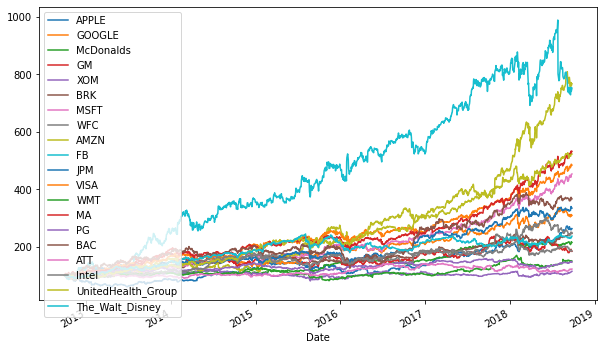

In [23]:
(data / data.iloc[0] * 100).plot(figsize=(10, 6))

In [24]:
log_returns = np.log(data / data.shift(1))
log_returns.head()

,APPLE,GOOGLE,McDonalds,GM,XOM,BRK,MSFT,WFC,AMZN,FB,JPM,VISA,WMT,MA,PG,BAC,ATT,Intel,UnitedHealth_Group,The_Walt_Disney
Date,,,,,,,,,,,,,,,,,,,,
2012-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-10-02,0.002908,-0.006308,-0.011590,0.025231,-0.000872,0.001705,0.005748,0.003452,-0.005611,0.012653,-0.001221,-0.005354,-0.004060,0.001662,-0.009549,-0.003354,0.001588,0.003509,0.006004,-0.008292
2012-10-03,0.015217,0.007252,-0.006399,0.029542,-0.000218,0.006270,0.006721,0.017649,0.021007,-0.019955,0.005891,0.018360,0.006083,0.034596,0.005509,0.019956,0.009476,-0.012778,0.001056,0.015945
2012-10-04,-0.006950,0.007252,0.007498,0.010604,0.005655,0.009029,0.005677,0.014844,0.017623,0.005482,0.023223,0.008268,0.006983,0.002361,0.003031,0.032401,0.004444,-0.003554,0.019333,0.003045
2012-10-05,-0.021541,-0.000521,-0.000330,0.006067,0.003572,0.002023,-0.006012,-0.003621,-0.007553,-0.048540,-0.002634,0.004215,0.005472,0.007159,0.003597,-0.009611,-0.001056,0.009303,-0.014596,0.006440


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faced70eb90>,
      dtype=object)

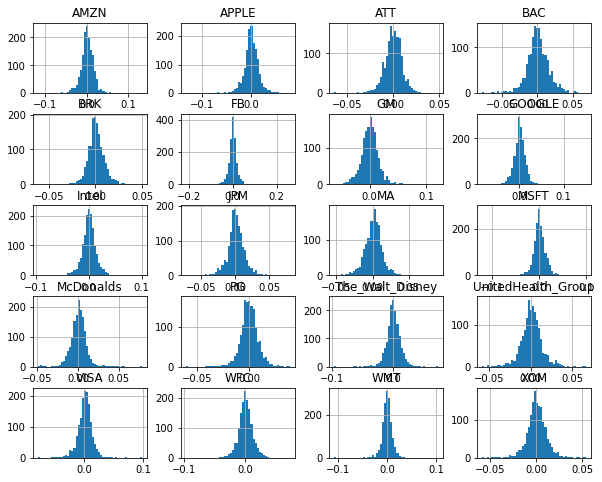

In [25]:
log_returns.hist(bins=50, figsize=(10, 8))

# 2, mean variance model
## (1) Model optimization

In [26]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

mu = expected_returns.mean_historical_return(data)
S = risk_models.sample_cov(data,frequency=252)

#mean variance model optimization
EF_min = EfficientFrontier(mu, S)

EF_min.min_volatility()
#portfolio performance
EF_min.portfolio_performance(verbose=True)

Expected annual return: 11.6%
Annual volatility: 10.6%
Sharpe Ratio: 0.90


(0.1155764576157817, 0.10646529100156261, 0.8977241006590485)

In [27]:
#CAPM optimization
#Enter non-risky asset
EF = EfficientFrontier(mu, S)
weights = EF.max_sharpe(risk_free_rate=risk_free_annual)
#Portfolio ratio
EF.portfolio_performance(verbose=True)

Expected annual return: 31.3%
Annual volatility: 16.0%
Sharpe Ratio: 1.83


(0.31330291556754775, 0.16004365290494513, 1.832643221045132)

In [28]:
#Weights in each stock
EF.clean_weights()

OrderedDict([('APPLE', 0.0),
             ('GOOGLE', 0.0),
             ('McDonalds', 0.02215),
             ('GM', 0.0),
             ('XOM', 0.0),
             ('BRK', 0.0),
             ('MSFT', 0.09304),
             ('WFC', 0.0),
             ('AMZN', 0.13933),
             ('FB', 0.10216),
             ('JPM', 0.0),
             ('VISA', 0.10452),
             ('WMT', 0.0),
             ('MA', 0.16295),
             ('PG', 0.0),
             ('BAC', 0.0),
             ('ATT', 0.0),
             ('Intel', 0.0),
             ('UnitedHealth_Group', 0.37584),
             ('The_Walt_Disney', 0.0)])

## (2) Download the data of each stock from September 13, 2019 to December 13, 2019 will be collected for simulation.

In [29]:
data2=pd.DataFrame([])
name2=["AAPL","GOOGL","MCD","GM","XOM","BRK-A","MSFT","WFC","AMZN","FB","JPM","V",
             "WMT","MA","PG","BAC","T","INTC","UNH","DIS"]

columns2=["APPLE","GOOGLE","McDonalds","GM","XOM","BRK","MSFT","WFC","AMZN","FB","JPM","VISA",
             "WMT","MA","PG","BAC","ATT","Intel","UnitedHealth_Group","The_Walt_Disney"]

for idx,stock in enumerate(name2):
    name = pdr.get_data_yahoo(stock, start=datetime.datetime(2018, 9, 25), 
                          end=datetime.datetime(2019, 9, 24))
    j=columns[idx]
    data2[j]=name["Adj Close"]

## (3) If managed from September 13, 2019 to December 13, 2019, the average return of the portfolio will be
## R = 1r1 + w2r2 + ... + wn * rn
## ri = Return of individual stock
## wi = weight of individual stock
## R = average revenue of the portfolio

In [30]:
Mean_variance_return=np.sum(np.array(EF.weights)*np.array(expected_returns.mean_historical_return(data2, frequency=252)))

In [31]:
Mean_variance_return

0.052360018732317506

## (4) Volatility of the mean variance model portfolio

In [337]:
from pypfopt import objective_functions
np.sqrt(objective_functions.portfolio_variance(EF.weights, risk_models.sample_cov(data2)))

0.22710330877002932

# 3. Black – Litterman model

## (1) For the simulation period, calculate the return of each issue from September 13, 2019 to December 13, 2019

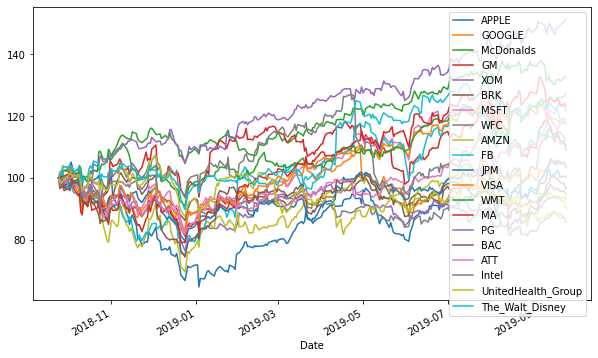

In [34]:
(data2 / data2.iloc[0] * 100).plot(figsize=(10, 6))

In [35]:
expected_returns.mean_historical_return(data2, frequency=252)

APPLE                 0.052789
GOOGLE                0.073778
McDonalds             0.299691
GM                    0.137557
XOM                  -0.132187
BRK                  -0.035906
MSFT                  0.232971
WFC                  -0.047611
AMZN                 -0.043119
FB                    0.147280
JPM                   0.057230
VISA                  0.194010
WMT                   0.258941
MA                    0.250547
PG                    0.434399
BAC                  -0.003515
ATT                   0.183480
Intel                 0.134533
UnitedHealth_Group   -0.122655
The_Walt_Disney       0.199716
dtype: float64

## (3) Setting critic reviews for each brand
## Referring to the above figures and data supposed that I could correctly predict the future returns after three months, by exactly same as the actual returns above.

In [310]:
from pypfopt.black_litterman import BlackLittermanModel
S = risk_models.sample_cov(data)

viewdict = expected_returns.mean_historical_return(data2, frequency=252)

In [311]:
bl = BlackLittermanModel(S, absolute_views=viewdict)
rets = bl.bl_returns()

/usr/local/anaconda3/lib/python3.7/site-packages/pypfopt/black_litterman.py:252: UserWarning: Running Black-Litterman with no prior.
  warnings.warn("Running Black-Litterman with no prior.")


## (4) Calculate the return of each brand

In [312]:
rets

APPLE                 0.083648
GOOGLE                0.096565
McDonalds             0.177183
GM                    0.102974
XOM                   0.006427
BRK                   0.047350
MSFT                  0.160205
WFC                   0.020119
AMZN                  0.059489
FB                    0.108543
JPM                   0.045620
VISA                  0.154352
WMT                   0.178605
MA                    0.159932
PG                    0.228743
BAC                   0.011720
ATT                   0.131412
Intel                 0.117798
UnitedHealth_Group   -0.000242
The_Walt_Disney       0.129512
dtype: float64

## (5) Introduce SP500 as market price

In [313]:
SP500 = pdr.get_data_yahoo('^GSPC', 
                          start=datetime.datetime(2012, 10, 1), 
                          end=datetime.datetime(2018, 9, 24))

In [314]:
market_prices=SP500["Close"]

In [315]:
# (market_prices.pct_change().values[1:].sum()/len(market_prices.pct_change().values[1:]))*252*8

## (6) The study period will be from October 1, 2012 to September 12, 2019.

In [316]:
from pypfopt import black_litterman

delta = black_litterman.market_implied_risk_aversion(market_prices,risk_free_rate=risk_free_annual)

ef = EfficientFrontier(rets, S)

bl.bl_weights(delta)
weights = bl.clean_weights()

In [317]:
bl.portfolio_performance(verbose=True)

Expected annual return: 38.6%
Annual volatility: 18.0%
Sharpe Ratio: 2.03


(0.38589191492619135, 0.18047881043504077, 2.027340018721399)

In [318]:
weights

OrderedDict([('APPLE', -0.04278),
             ('GOOGLE', -0.03735),
             ('McDonalds', 0.42499),
             ('GM', 0.0444),
             ('XOM', -0.3792),
             ('BRK', -0.32059),
             ('MSFT', 0.11836),
             ('WFC', -0.15168),
             ('AMZN', -0.10267),
             ('FB', 0.0267),
             ('JPM', 0.02304),
             ('VISA', 0.08153),
             ('WMT', 0.20143),
             ('MA', 0.18465),
             ('PG', 0.84262),
             ('BAC', -0.01968),
             ('ATT', 0.16188),
             ('Intel', 0.02564),
             ('UnitedHealth_Group', -0.25202),
             ('The_Walt_Disney', 0.17074)])

In [319]:
sum(weights.values())

1.00001

## (7) If managed from September 13, 2019 to December 13, 2019, the average return of the portfolio will be
## R = 1r1 + w2r2 + ... + wn * rn
## ri = Return of individual stock
## wi = weight of individual stock
## R = average revenue of the portfolio

In [320]:
BL_return=np.sum(np.array(bl.weights)*np.array(expected_returns.mean_historical_return(data2, frequency=252)))

In [321]:
BL_return

0.8130689012674709

## (8) Portfolio volatility

In [338]:
from pypfopt import objective_functions
np.sqrt(objective_functions.portfolio_variance(bl.weights, risk_models.sample_cov(data2)))

0.23919317650072078

## 4. Machine Learning Optimization, Nested Clustered Optimization algorithm(NCO), Convex Optimization Solution(CVO) and Monte Carlo approach(MCOS)

## (1)Calculate the Return of Data

In [323]:
data_return=data.pct_change().fillna(0)

## (2)Optimization of NCO & CVO

In [387]:
import pandas as pd
from mlfinlab.portfolio_optimization import NCO
max_num_clusters = 19

# Import dataframe of returns for assets in a portfolio


# Calculate empirical covariance of assets
assets_cov = np.array(data_return.cov())

# Calculate empirical means of assets
assets_mean = np.array(data_return.mean()).reshape(-1, 1)

# Class that contains needed functions
nco = NCO()

# Find optimal weights using the NCO algorithm
w_nco = nco.allocate_nco(assets_cov, assets_mean,max_num_clusters)

# Find optimal weights using the CVO algorithm
w_cvo = nco.allocate_cvo(assets_cov, assets_mean)

# Compare the NCO solutions to the CVO ones using MCOS
# Parameters are: 10 simulations, 100 observations in a simulation
# goal of minimum variance, no LW shrinkage

In [388]:
w_nco/sum(w_nco)

array([[ 0.03519888],
       [-0.02932606],
       [ 0.11614586],
       [-0.02749567],
       [-0.1056953 ],
       [ 0.04811056],
       [ 0.05864416],
       [-0.10869697],
       [ 0.071867  ],
       [ 0.07736821],
       [ 0.02657243],
       [ 0.10035062],
       [ 0.03062617],
       [ 0.31931698],
       [-0.03625111],
       [ 0.08822214],
       [-0.01531096],
       [ 0.03772505],
       [ 0.30346834],
       [ 0.0091597 ]])

## (3)Return of NCO method

In [389]:
NCO_return=np.sum((w_nco/sum(w_nco)).flatten()*np.array(expected_returns.mean_historical_return(data2, frequency=252)))

In [390]:
NCO_return

0.12983769963878486

## (4)Return of CVO method

In [391]:
CVO_return=np.sum((w_cvo/sum(w_cvo)).flatten()*np.array(expected_returns.mean_historical_return(data2, frequency=252)))

In [392]:
CVO_return

0.15772837375294288

## (5)Variance of NCO method

In [468]:
NCO_volatility=np.sqrt(objective_functions.portfolio_variance((w_nco/sum(w_nco)).flatten(), risk_models.sample_cov(data2)))

In [480]:
NCO_volatility

0.22761822576741092

## (6)Variance of CVO method

In [470]:
CVO_volatility=np.sqrt(objective_functions.portfolio_variance((w_cvo/sum(w_cvo)).flatten(), risk_models.sample_cov(data2)))

In [471]:
CVO_volatility

0.3153933467170092

## (7)Optimization of MCOS(Parameters are: 10 simulations, 100 observations in a simulation)

In [397]:
w_cvo_mcos, w_nco_mcos = nco.allocate_mcos(assets_mean, assets_cov, 100, 10, 0.01, True, False)

# Find the errors in estimations of NCO and CVO in simulations
err_cvo_mcos, err_nco_mcos = nco.estim_errors_mcos(w_cvo, w_nco, assets_mean, assets_cov, True)

## (8)Summary the returns of each simulation

In [398]:
np.sum(w_nco_mcos*np.array(expected_returns.mean_historical_return(data2, frequency=252)),axis=1)

0    0.159614
1    0.221622
2    0.195115
3    0.170084
4    0.167117
5    0.216922
6    0.245414
7    0.147076
8    0.214264
9    0.189586
dtype: float64

## (9)Average return of all simulations

In [463]:
nco_mcos_return=sum(np.sum(w_nco_mcos*np.array(expected_returns.mean_historical_return(data2, frequency=252)),axis=1))/10

In [464]:
nco_mcos_return

0.19268138396419188

In [466]:
cvo_mcos_return=sum(np.sum(w_cvo_mcos*np.array(expected_returns.mean_historical_return(data2, frequency=252)),axis=1))/10

In [467]:
cvo_mcos_return

0.19675876865353487

## (10)Average volatility of all simulations

In [472]:
values=[]
for i in range(10):
    value=np.sqrt(objective_functions.portfolio_variance(np.array(w_nco_mcos.iloc[i]), risk_models.sample_cov(data2)))
    values.append(value)
nco_mcos_volatility = np.array(values)

In [473]:
nco_mcos_volatility

array([0.13353141, 0.14042089, 0.1378306 , 0.13789167, 0.13257459,
       0.13626064, 0.13215834, 0.14059929, 0.13711318, 0.13598299])

In [478]:
sum(nco_mcos_volatility)/10

0.1364363597337288

In [475]:
values=[]
for i in range(10):
    value=np.sqrt(objective_functions.portfolio_variance(np.array(w_cvo_mcos.iloc[i]), risk_models.sample_cov(data2)))
    values.append(value)
cvo_mcos_volatility = np.array(values)

In [476]:
cvo_mcos_volatility

array([0.13427791, 0.13846402, 0.13666899, 0.13849846, 0.13438237,
       0.13528773, 0.13497147, 0.14359841, 0.13723413, 0.1390172 ])

In [477]:
sum(cvo_mcos_volatility)/10

0.1372400683540239

# 4, Portfolio comparison

## (1) Portfolio weight comparison

In [420]:
(w_nco_mcos*np.array(expected_returns.mean_historical_return(data2, frequency=252))).T.iloc[0]

0   -0.002389
1   -0.002020
2    0.000685
3    0.003964
4    0.000802
5    0.001641
6    0.000725
7    0.001648
8    0.001202
9   -0.000728
Name: 0, dtype: float64

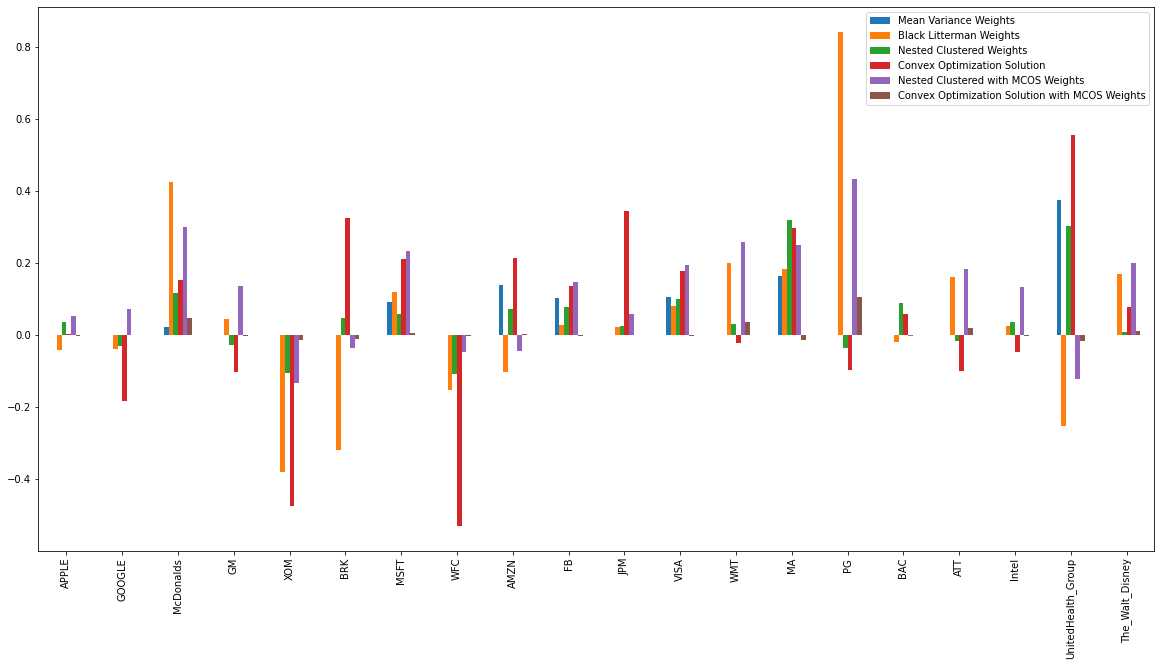

In [462]:
df = pd.DataFrame([EF.weights.reshape(20),np.array(list(bl.weights)).reshape(20),(w_nco/sum(w_nco)).reshape(20),\
                   (w_cvo/sum(w_cvo)).reshape(20),np.array(expected_returns.mean_historical_return(data2, frequency=252)),\
                   (w_cvo_mcos.iloc[0]*np.array(expected_returns.mean_historical_return(data2, frequency=252)))],
                  columns=["APPLE","GOOGLE","McDonalds","GM","XOM","BRK","MSFT","WFC","AMZN","FB","JPM","VISA",
             "WMT","MA","PG","BAC","ATT","Intel","UnitedHealth_Group","The_Walt_Disney"],
                  index=['Mean Variance Weights','Black Litterman Weights','Nested Clustered Weights','Convex Optimization Solution',\
                         'Nested Clustered with MCOS Weights','Convex Optimization Solution with MCOS Weights'])
df.T.plot(kind='bar',figsize=(20, 10))

## (2) Analysis
## Weights have been newly calculated for the Black Litterman model as maximum return of portfolio compare to other portfolios of optimization.

## (3) Comparison of simulated portfolios average return and volatility

In [489]:
risk_free_3months=risk_free_annual/4

In [495]:
df2 = pd.DataFrame([[Mean_variance_return,BL_return,NCO_return,CVO_return,\
                    nco_mcos_return,cvo_mcos_return],\
                    [np.sqrt(objective_functions.portfolio_variance\
                                                 (EF.weights, risk_models.sample_cov(data2))),\
                    np.sqrt(objective_functions.portfolio_variance(bl.weights, risk_models.sample_cov(data2)))
                    ,np.average(nco_volatility),np.average(cvo_volatility),np.average(nco_mcos_volatility),np.average(cvo_mcos_volatility)],\
                    [(Mean_variance_return-risk_free_annual)/np.sqrt(objective_functions.portfolio_variance(EF.weights, risk_models.sample_cov(data2))),\
                     (BL_return-risk_free_3months)/np.sqrt(objective_functions.portfolio_variance(bl.weights, risk_models.sample_cov(data2)))\
                     ,(NCO_return-risk_free_3months)/np.average(nco_volatility),(CVO_return-risk_free_3months)/np.average(cvo_volatility),\
                    (nco_mcos_return-risk_free_3months)/np.average(nco_mcos_volatility),(cvo_mcos_return-risk_free_3months)/np.average(cvo_mcos_volatility)\
                    ]],columns=["Mean Variance simulated value","Black Litterman simulated value",'Nested Clustered simulated value','Convex Optimization simulated value',\
                         'Nested Clustered with MCOS simulated value','Convex Optimization Solution with MCOS simulated value'],index=["Return","Volatility","Portfolio Sharpe Ratio"])
    
df2

,Mean Variance simulated value,Black Litterman simulated value,Nested Clustered simulated value,Convex Optimization simulated value,Nested Clustered with MCOS simulated value,Convex Optimization Solution with MCOS simulated value
Return,0.052360,0.813069,0.129838,0.157728,0.192681,0.196759
Volatility,0.227103,0.239193,0.136436,0.137240,0.136436,0.137240
Portfolio Sharpe Ratio,0.212055,3.394823,0.943937,1.141634,1.404545,1.426029


# 5, conclusion
## From September 25, 2018 to September 24, 2019, the mean variance model and the Black Litterman model were compared, the average revenue of the portfolio was calculated, and the Black Litterman model was adopted.  We improved Black Litterman model as maximum return of portfolio compare to other portfolios of optimization.
## The average return of Black Litterman simulated value is  much higher than the expected annual return of Black Litterman expected value and the annual return of Mean Variance expected value.
## The Return and  Sharpe Ratio of Convex Optimization Solution with MCOS and Nested Clustered with MCOS  resulted in highest return than those without MCOS method which mean MCOS method is prefer.
## The Return and  Sharpe Ratio of Convex Optimization Solution are litter higher than Nested Clustered with MCOS   which mean Convex Optimization Solution with MCOS is better.
## Although reading related research papers may seem obvious, but those who believe they have better information than others suggest that they perform better than market-average portfolios. In portfolio management, it is important to perform not only algorithms but also critic information, market information, and most importantly, corporate analysis.

# 6, reference list
##  translated by David G. Ruenberger, Hiroshi Konno, Kenichi Suzuki, Norio Bibiki, "Introduction to Financial Engineering: Second Edition," Nihon Keizai Shimbun (2015)
## Takahiro Komatsu “Optimal Investment Strategy” Asakura Shoten (2018)
## PyPortfolioOpt, https://pyportfolioopt.readthedocs.io/en/latest/
## Machine Learning Financial Laboratory (mlfinlab) https://mlfinlab.readthedocs.io/en/latest/index.html
## A ROBUST ESTIMATOR OF THE EFFICIENT FRONTIER https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3469961
## López de Prado Machine Learning for Asset Managers
## López de Prado Advances in Financial Machine Learning